# Transition Matrices: computing and styling
+ PNG files were created and converted to Base64 to render the styles applied in the transition matrices in Github.
+ A duplicate entry was identified in the Fortune 500 Global list of 2020 referring to Shandong Energy Group. The deletion of this record impacts the probabilities of the segment comprised of companies which entered or were dropped from the Fortune ranking.  

## 1. Compute the transition matrix

In [1]:
import pandas as pd
import numpy as np
import os

## LOAD DATA
path_parent_dir = os.path.dirname(os.getcwd())
path_data = f'{path_parent_dir}\data'
path_data_input = f'{path_data}\input_data'
path_data_support = f'{path_data}\support_data'
df_input_data = pd.read_csv(f'{path_data_input}/transition_matrices_input.csv',sep=';')
df_segment_rules = pd.read_csv(f'{path_data_support}/transition_matrices_segment_rules.csv',sep=';')

## DATA FILTERING
## 4-YEAR TRANSITION MATRIX BASED ON PROFIT 
df_profit = df_input_data.iloc[:,np.r_[0,6,9,2,5,-4,-1]][(df_input_data['measure']=='profits_m')
                                                          &
                                                          ((df_input_data['matrix_class_2023']!='na_class')
                                                          |
                                                          (df_input_data['matrix_class_2020']!='na_class'))].reset_index(drop=True).copy()

df_profit = df_profit.sort_values(by=['value_2023'], ascending=[False])
df_profit[['matrix_class_2020','matrix_class_2023']] = df_profit[['matrix_class_2020','matrix_class_2023']].replace('na_class','NE/DfR')

## SUPPORT LISTS ON THE PROFIT CLASSES 
list_matrix_class_y = [']0% ; 10%]',']10% ; 20%]',']20% ; 30%]',']30% ; 40%]',']40% ; 50%]',
                       ']50% ; 60%]',']60% ; 70%]',']70% ; 80%]',']80% ; 90%]',']90% ; 100%]','<=0', 'NE/DfR','All'] 
list_matrix_class_y_prev = [']0% ; 10%]',']10% ; 20%]',']20% ; 30%]',']30% ; 40%]',']40% ; 50%]',
                            ']50% ; 60%]',']60% ; 70%]',']70% ; 80%]',']80% ; 90%]',']90% ; 100%]','<=0', 'NE/DfR','All']

## COMPUTE THE TRANSITION MATRIX BY USING A CROSSTAB
df_crosstab_norm = pd.crosstab(df_profit.matrix_class_2020,
                               df_profit.matrix_class_2023,
                               rownames=['Y2020'],
                               colnames=['Y2023'],
                               margins=True,
                               normalize=True).reindex(list_matrix_class_y_prev)[list_matrix_class_y]

df_crosstab_norm = df_crosstab_norm*100

## 2. Style the transition matrix
### 2.1. 4-Year profit transition matrix

In [2]:
def set_background_color(df):
    """
    To set the background color of the multiple transition matrix segments
    Based on the approach proposed on Stack Overflow by anky (question 57595257, Aug 21 2019)
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """ 
    ## 1. LIGHT REDS SEGMENT (UPPER TRIANGULAR EXCEPT THE LARGEST RECTANGLE INSIDE OF IT)
    ## INTERMEDIARY AND SLIGHT DOWNGRADES 
    mask_light_reds = np.triu(np.ones(df_crosstab_norm.shape),1).astype(bool)
    mask_light_reds[:,np.shape(mask_light_reds)[1]-2:]=False
    mask_light_reds[:5,6:-2]=False
    ## 2. DARK REDS SEGMENT (LARGEST RECTANGLE OF THE UPPER TRIANGULAR)
    ## STEEP DOWNGRADES 
    mask_dark_reds = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_dark_reds[:5,6:-2]=True
    ## 3. LIGHT GREENS SEGMENT (LOWER TRIANGULAR EXCEPT THE LARGEST RECTANGLE INSIDE OF IT)
    ## INTERMEDIARY AND SLIGHT UPGRADES
    mask_light_greens = np.tril(np.ones(df_crosstab_norm.shape),-1).astype(bool)
    mask_light_greens[np.shape(mask_light_greens)[0]-2:]=False
    mask_light_greens[6:-2,:5]=False
    ## 4. DARK GREENS SEGMENT (LARGEST RECTANGLE OF THE LOWER TRIANGULAR)
    ## STEEP POSITIVE UPGRADES 
    mask_dark_greens = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_dark_greens[6:-2,:5]=True
    ## 5. YELLOWS SEGMENT (DIAGONAL): NO RANKING CHANGES    
    mask_yellows = np.eye(np.ones(df_crosstab_norm.shape).shape[0], dtype=bool)
    mask_yellows[np.shape(mask_yellows)[0]-2:,np.shape(mask_yellows)[1]-2:]=False
    ## 6. BLUE-BROWN SEGMENT: NEW ENTRIES AND COMPANIES DROPPED FROM FORTUNE GLOBAL 500
    mask_blues = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_blues[np.shape(mask_blues)[0]-2:np.shape(mask_blues)[0]-1,:np.shape(mask_yellows)[1]-2]=True
    mask_browns = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_browns[:np.shape(mask_browns)[0]-2,np.shape(mask_yellows)[1]-2:np.shape(mask_yellows)[1]-1]=True
   
    ## COLORS
    light_red = 'background-color: #ff7b7b'
    dark_red = 'background-color: #ff0000'
    light_green = 'background-color: #21D375'
    dark_green = 'background-color: #019875'
    light_orange = 'background-color: #ffc100'
    blue = 'background-color: #3876BF'
    brown = 'background-color: #DFA878'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_light_reds,mask_dark_reds,mask_light_greens,mask_dark_greens,
                                   mask_yellows,mask_blues,mask_browns],
                                  [light_red,dark_red,light_green,dark_green,light_orange,blue,brown],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

## STYLE THE TRANSITION MATRIX 
four_year_profit_tm = (df_crosstab_norm.style
                                       .set_table_styles([{"selector":"th.row_heading","props":[("background-color","white")]},
                                                          {"selector":"th","props":[('text-align', 'center')]},
                                                          {'selector': 'th','props': [('border', '1px white solid !important')]}])
                                       .set_properties(**{'color': 'white',
                                                          'border': '1px white solid !important',
                                                          'text-align': 'center',
                                                          'width': '45px',
                                                          'max-width': '45px'})
                                       .apply(set_background_color, axis=None)
                                       .format('{:.2f}')
                       )

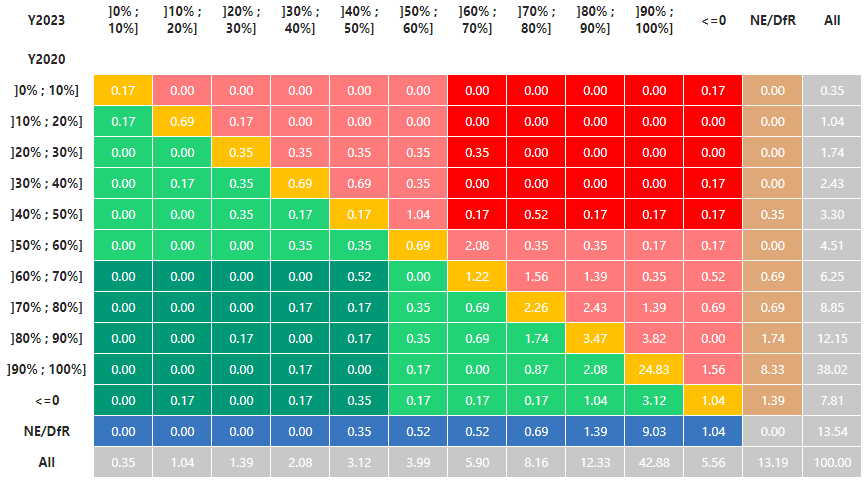

### 2.2. Complementar segment analysis
#### 2.2.1. Overall upgrade likelihood

In [3]:
def style_tm_segment(df,func):
    """
    To style specific segments of the transition matrix
    
    Args:
        df : DataFrame
        func : function
        
    Returns:
        DataFrame
    """
    return (df.style
              .set_table_styles([{"selector":"th.row_heading","props":[("background-color","white")]}
                                 ,
                                 {"selector":"th","props":[('text-align', 'center')]}
                                 ,
                                 {'selector': 'th','props': [('border', '1px white solid !important')]}])
              .set_properties(**{'color': 'white',
                                 'border': '1px white solid !important',
                                 'text-align': 'center',
                                 'width': '45px',
                                 'max-width': '45px'})
              .apply(func, axis=None)
              .format('{:.2f}')
            )

def set_l_triang_bg_color(df):
    """
    To set the background color of the lower triangular of the transition matrix
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """
    mask_lower_triang = np.tril(np.ones(df_crosstab_norm.shape),-1).astype(bool)
    mask_lower_triang[np.shape(mask_lower_triang)[0]-2:]=False

    light_green = 'background-color: #21D375'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_lower_triang],[light_green],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

upgrade_likelihood_tm = style_tm_segment(df_crosstab_norm,set_l_triang_bg_color)

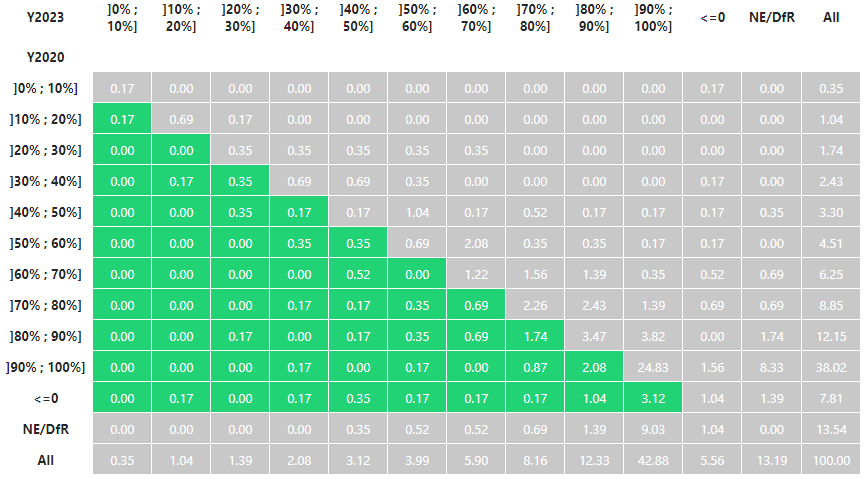

In [4]:
upgrade_likelihood = round(np.tril(df_crosstab_norm,-1).sum() - df_crosstab_norm.iloc[-2:,:-1].values.sum(),1)
print(f'The likelihood of a company showing a positive transition between the profit classes is {upgrade_likelihood}%')

The likelihood of a company showing a positive transition between the profit classes is 15.6%


##### Check out the Top 10 companies which experienced a positive transition

In [23]:
def filter_segment(list_segments):
    """
    To filter out any segment(s) of the transition matrix and pre format the dataframe
    
    Args:
        list_segments : list
        
    Returns:
        DataFrame
    """
    df = df_profit[(df_profit['segment'].isin(list_segments))].copy()
    list_num_cols = df.select_dtypes(include=np.number).columns.tolist()
    df[list_num_cols] = df[list_num_cols].astype(int)
    return df

## SEGMENT ASSIGMENT PER ROW
list_rules = []

for i, j in zip(df_segment_rules['past_year'].tolist(),df_segment_rules['year'].tolist()):
    list_rules.extend(eval(f"[(df_profit.iloc[:,-3]=='{i}') & (df_profit.iloc[:,-2]=='{j}')]"))

df_profit['segment'] = np.select(list_rules,df_segment_rules['segment'].tolist(),default='N/A')

## FILTERING OUT THE LIGHT GREEN AND THE DARK GREEN SEGMENTS
ranking_upgrades = filter_segment(['light_greens','dark_greens'])
ranking_upgrades.head(10).style.hide(axis='index')

name,rank_2020,rank_2023,value_2020,value_2023,matrix_class_2020,matrix_class_2023,segment
Apple,3,2,55256,99803,]10% ; 20%],]0% ; 10%],light_greens
U.S. Postal Service,480,5,-8813,56046,<=0,]10% ; 20%],dark_greens
Exxon Mobil,27,6,14340,55740,]30% ; 40%],]10% ; 20%],light_greens
Samsung Electronics,21,9,18453,42398,]30% ; 40%],]20% ; 30%],light_greens
Shell,23,10,15842,42309,]30% ; 40%],]20% ; 30%],light_greens
Petrobras,48,13,10151,36623,]40% ; 50%],]20% ; 30%],light_greens
Chevron,209,14,2924,35465,]80% ; 90%],]20% ; 30%],dark_greens
Taiwan Semiconductor Manufacturing,41,16,11452,33343,]40% ; 50%],]20% ; 30%],light_greens
BHP Group,64,18,8306,30900,]50% ; 60%],]30% ; 40%],light_greens
Maersk Group,441,19,-84,29198,<=0,]30% ; 40%],dark_greens


#### 2.2.2. Steep upgrade likelihood: moving from the lower to the upper classes  

In [6]:
def set_dark_green_seg_bg_color(df):
    """
    To set the background color of the dark greens segment
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """
    mask_dark_greens = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_dark_greens[6:-2,:5]=True

    dark_green = 'background-color: #019875'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_dark_greens],[dark_green],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

steep_upgrade_likelihood_tm = style_tm_segment(df_crosstab_norm,set_dark_green_seg_bg_color)

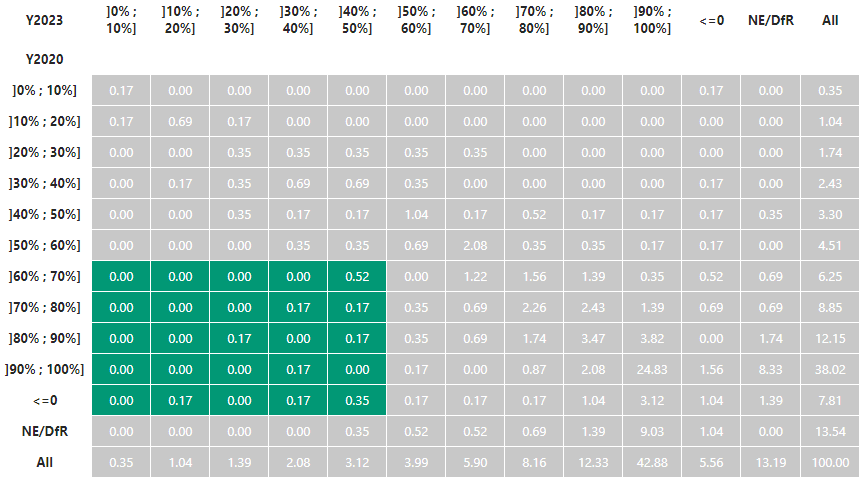

In [7]:
steep_upgrade_likelihood = round(df_crosstab_norm.iloc[6:-2,:5].values.sum(),1)
print(f'The likelihood of a company showing a steep positive transition between the \
profit classes is {steep_upgrade_likelihood}%')

The likelihood of a company showing a steep positive transition between the profit classes is 2.1%


##### Companies which experienced a steep upgrade

In [24]:
## FILTERING OUT THE THE DARK GREEN SEGMENT
ranking_upgrade_transition = filter_segment(['dark_greens'])
ranking_upgrade_transition.style.hide(axis='index')

name,rank_2020,rank_2023,value_2020,value_2023,matrix_class_2020,matrix_class_2023,segment
U.S. Postal Service,480,5,-8813,56046,<=0,]10% ; 20%],dark_greens
Chevron,209,14,2924,35465,]80% ; 90%],]20% ; 30%],dark_greens
Maersk Group,441,19,-84,29198,<=0,]30% ; 40%],dark_greens
Equinor,261,20,1843,28746,]90% ; 100%],]30% ; 40%],dark_greens
China National Petroleum,130,25,4443,21080,]70% ; 80%],]30% ; 40%],dark_greens
BMW Group,105,30,5501,18870,]60% ; 70%],]40% ; 50%],dark_greens
Vale,468,31,-1683,18788,<=0,]40% ; 50%],dark_greens
GSK,93,33,5927,18439,]60% ; 70%],]40% ; 50%],dark_greens
Glencore,455,39,-404,17320,<=0,]40% ; 50%],dark_greens
China National Offshore Oil,78,41,6957,16988,]60% ; 70%],]40% ; 50%],dark_greens


#### 2.2.3. Overall downgrade likelihood

In [9]:
def set_u_triang_bg_color(df):
    """
    To set the background color of the upper triangular of the transition matrix
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """
    mask_upper_triang = np.triu(np.ones(df_crosstab_norm.shape),1).astype(bool)
    mask_upper_triang[:,np.shape(mask_upper_triang)[1]-2:]=False

    light_red = 'background-color: #ff7b7b'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_upper_triang],[light_red],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

downgrade_likelihood_tm = style_tm_segment(df_crosstab_norm,set_u_triang_bg_color)

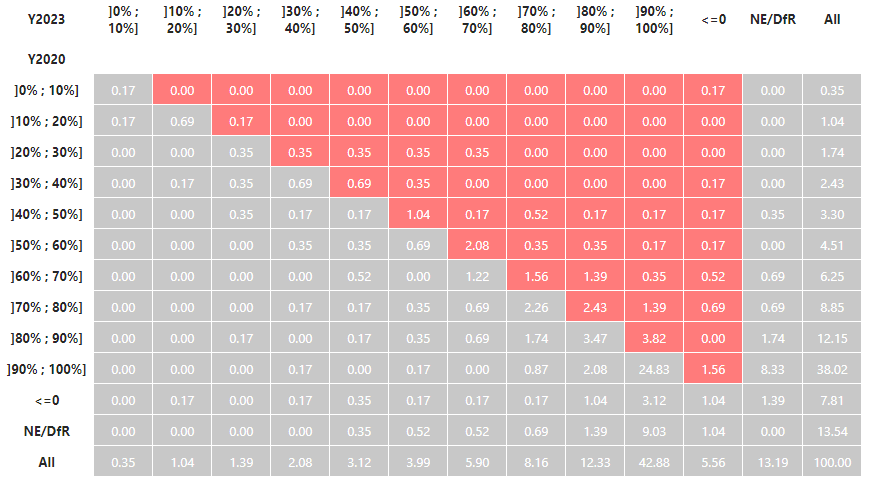

In [10]:
downgrade_likelihood = round(np.triu(df_crosstab_norm,1).sum() - df_crosstab_norm.iloc[:-1,-2:].values.sum(),1)
print(f'The likelihood of a company showing a negative transition between the profit classes is {downgrade_likelihood}%')

The likelihood of a company showing a negative transition between the profit classes is 22.0%


##### Bottom 10 companies which experienced a downgrade

In [25]:
## FILTERING OUT THE LIGHT RED AND THE DARK RED SEGMENTS
downgrade_transition = filter_segment(['light_reds','dark_reds'])
downgrade_transition.sort_values(by=['rank_2023'], ascending=[False]).head(10).style.hide(axis='index')

name,rank_2020,rank_2023,value_2020,value_2023,matrix_class_2020,matrix_class_2023,segment
Berkshire Hathaway,2,491,81417,-22819,]0% ; 10%],<=0,dark_reds
Uniper,358,490,683,-19961,]90% ; 100%],<=0,light_reds
Electricité de France,97,488,5770,-18869,]60% ; 70%],<=0,light_reds
AT&T,29,486,13903,-8524,]30% ; 40%],<=0,dark_reds
State Farm Insurance,102,483,5593,-6654,]60% ; 70%],<=0,light_reds
CPC,328,482,1050,-6299,]90% ; 100%],<=0,light_reds
Amazon,40,480,11588,-2722,]40% ; 50%],<=0,dark_reds
BP,151,479,4026,-2487,]70% ; 80%],<=0,light_reds
Ford Motor,432,478,47,-1981,]90% ; 100%],<=0,light_reds
Prudential Financial,144,477,4186,-1438,]70% ; 80%],<=0,light_reds


#### 2.2.4. Steep downgrade likelihood: moving from the upper to the lower classes

In [12]:
def set_dark_red_seg_bg_color(df):
    """
    To set the background color of the dark reds segmemt
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """
    mask_dark_reds = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_dark_reds[:5,6:-2]=True

    dark_red = 'background-color: #ff0000'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_dark_reds],[dark_red],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

steep_downgrade_likelihood_tm = style_tm_segment(df_crosstab_norm,set_dark_red_seg_bg_color)

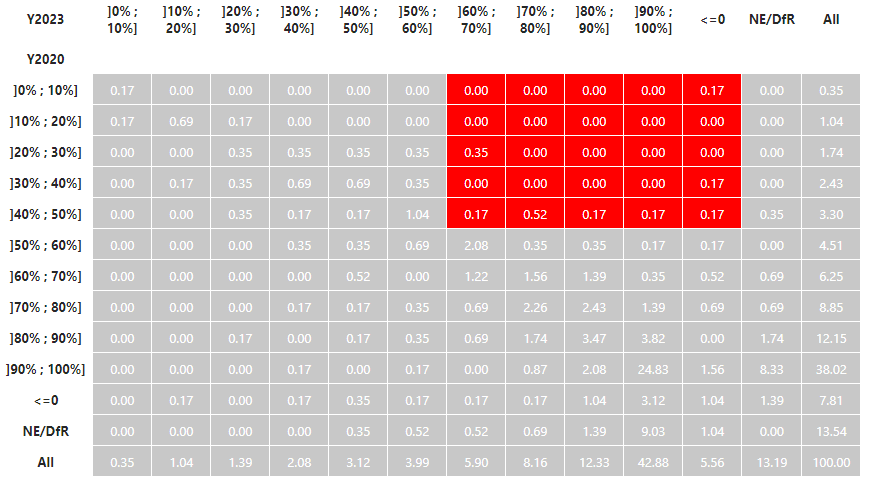

In [13]:
steep_downgrade_likelihood = round(df_crosstab_norm.iloc[:5,6:-2].values.sum(),1)
print(f'The likelihood of a company showing a steep negative transition between the \
profit classes is {steep_downgrade_likelihood}%')

The likelihood of a company showing a steep negative transition between the profit classes is 1.9%


##### Companies which experienced a steep downgrade

In [26]:
## FILTERING OUT THE THE DARK RED SEGMENT
ranking_steep_downgrade = filter_segment(['dark_reds'])
ranking_steep_downgrade.sort_values(by=['rank_2023'], ascending=[False]).style.hide(axis='index')

name,rank_2020,rank_2023,value_2020,value_2023,matrix_class_2020,matrix_class_2023,segment
Berkshire Hathaway,2,491,81417,-22819,]0% ; 10%],<=0,dark_reds
AT&T,29,486,13903,-8524,]30% ; 40%],<=0,dark_reds
Amazon,40,480,11588,-2722,]40% ; 50%],<=0,dark_reds
Walt Disney,46,227,11054,3145,]40% ; 50%],]90% ; 100%],dark_reds
Sberbank,34,201,13060,3959,]40% ; 50%],]80% ; 90%],dark_reds
Comcast,35,149,13057,5370,]40% ; 50%],]70% ; 80%],dark_reds
Oracle,45,123,11083,6717,]40% ; 50%],]70% ; 80%],dark_reds
Novartis,38,115,11732,6955,]40% ; 50%],]70% ; 80%],dark_reds
Intel,14,99,21048,8014,]20% ; 30%],]60% ; 70%],dark_reds
Nestlé,36,80,12546,9712,]40% ; 50%],]60% ; 70%],dark_reds


#### 2.2.5. No ranking changes

In [15]:
def set_no_changes_bg_color(df):
    """
    To set the background color of the diagonal of the transition matrix
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """
    mask_diagonal = np.eye(np.ones(df_crosstab_norm.shape).shape[0], dtype=bool)
    mask_diagonal[np.shape(mask_diagonal)[0]-2:,np.shape(mask_diagonal)[1]-2:]=False

    light_orange = 'background-color: #ffc100'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_diagonal],[light_orange],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

no_ranking_changes_tm = style_tm_segment(df_crosstab_norm,set_no_changes_bg_color)

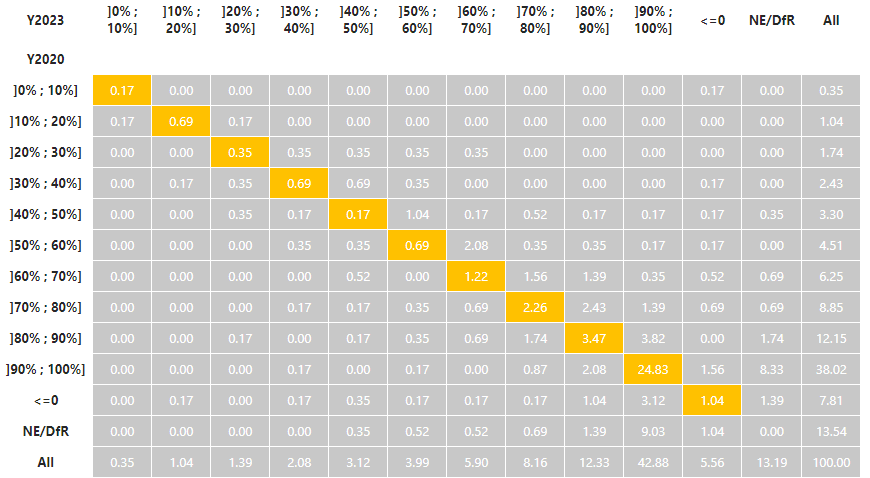

In [16]:
no_change_likelihood = round(np.trace(df_crosstab_norm.to_numpy()) - (df_crosstab_norm.iloc[-2,-2] + df_crosstab_norm.iloc[-1,-1]),1)
print(f'The likelihood of a company keeping stable across the profit classes is {no_change_likelihood}%')

The likelihood of a company keeping stable across the profit classes is 35.6%


##### Companies which kept stable

In [27]:
## FILTERING OUT THE YELLOW SEGMENT
no_ranking_changes = filter_segment(['yellows'])
print('Top 5')
no_ranking_changes.head(5).style.hide(axis='index')

Top 5


name,rank_2020,rank_2023,value_2020,value_2023,matrix_class_2020,matrix_class_2023,segment
Saudi Aramco,1,1,88211,159069,]0% ; 10%],]0% ; 10%],yellows
Microsoft,5,3,39240,72738,]10% ; 20%],]10% ; 20%],yellows
Alphabet,8,4,34343,59972,]10% ; 20%],]10% ; 20%],yellows
Industrial & Commercial Bank of China,4,7,45195,53589,]10% ; 20%],]10% ; 20%],yellows
China Construction Bank,6,8,38610,48145,]10% ; 20%],]10% ; 20%],yellows


In [28]:
print('Bottom 5')
no_ranking_changes.sort_values(by=['rank_2023'], ascending=[False]).head(5).style.hide(axis='index')

Bottom 5


name,rank_2020,rank_2023,value_2020,value_2023,matrix_class_2020,matrix_class_2023,segment
Korea Electric Power,473,489,-2013,-18954,<=0,<=0,yellows
SoftBank Group,481,484,-8844,-7167,<=0,<=0,yellows
Boeing,457,481,-636,-4935,<=0,<=0,yellows
Metro,446,465,-142,-361,<=0,<=0,yellows
Renault,447,464,-158,-356,<=0,<=0,yellows


#### 2.2.6. New entries and companies dropped from Fortune Global 500

In [19]:
def set_ne_dfr_bg_color(df):
    """
    To set the background color of the companies which entered or fell off the Fortune Global 500
    
    Args:
        df : DataFrame
        
    Returns:
        DataFrame
    """
    mask_yellows = np.eye(np.ones(df_crosstab_norm.shape).shape[0], dtype=bool)
    mask_yellows[np.shape(mask_yellows)[0]-2:,np.shape(mask_yellows)[1]-2:]=False
    mask_blues = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_blues[np.shape(mask_blues)[0]-2:np.shape(mask_blues)[0]-1,:np.shape(mask_yellows)[1]-2]=True
    mask_browns = (np.ones(df_crosstab_norm.shape)>1).astype(bool)
    mask_browns[:np.shape(mask_browns)[0]-2,np.shape(mask_yellows)[1]-2:np.shape(mask_yellows)[1]-1]=True

    blue = 'background-color: #3876BF'
    brown = 'background-color: #DFA878'
    grey = 'background-color: #C8C8C8'
        
    return pd.DataFrame(np.select([mask_blues,mask_browns],[blue,brown],grey),
                                  columns=df_crosstab_norm.columns,
                                  index=df_crosstab_norm.index)

ne_dfr_tm = style_tm_segment(df_crosstab_norm,set_ne_dfr_bg_color)

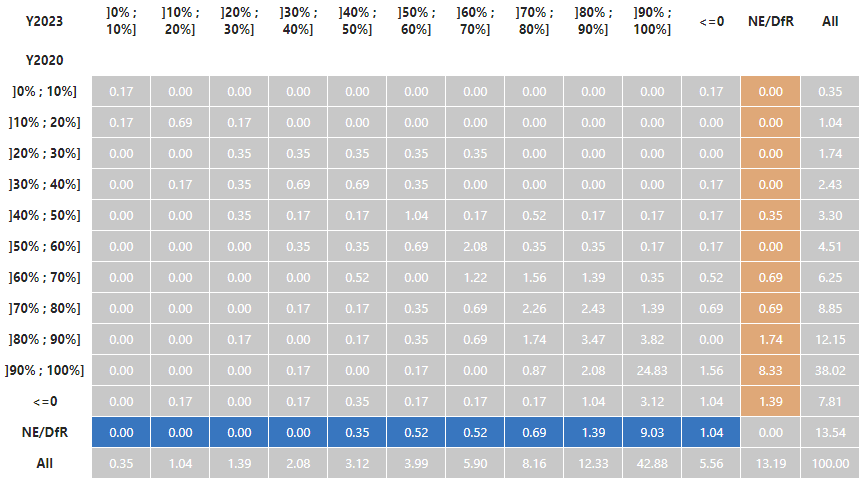

In [20]:
ne_dfr_likelihood = round(df_crosstab_norm.iloc[-1,-2],1)
print(f'The likelihood of a company joining or falling off the Fortune Global 500 is {ne_dfr_likelihood}%')

The likelihood of a company joining or falling off the Fortune Global 500 is 13.2%


In [29]:
## FILTERING OUT THE BLUE-BROWN SEGMENT
ranking_blues = filter_segment(['blue_brown'])
ranking_blues = ranking_blues[(ranking_blues['matrix_class_2020']=='NE/DfR')]
print('Top 10 Fortune Global 500 new entries')
ranking_blues.head(10).style.hide(axis='index')

Top 10 Fortune Global 500 new entries


name,rank_2020,rank_2023,value_2020,value_2023,matrix_class_2020,matrix_class_2023,segment
Hapag-Lloyd,0,36,0,17912,NE/DfR,]40% ; 50%],blue_brown
Stellantis,0,37,0,17669,NE/DfR,]40% ; 50%],blue_brown
Occidental Petroleum,0,54,0,13304,NE/DfR,]50% ; 60%],blue_brown
Qualcomm,0,57,0,12936,NE/DfR,]50% ; 60%],blue_brown
Tesla,0,60,0,12556,NE/DfR,]50% ; 60%],blue_brown
Broadcom,0,70,0,11495,NE/DfR,]60% ; 70%],blue_brown
Canadian Natural Resources,0,92,0,8404,NE/DfR,]60% ; 70%],blue_brown
Nutrien,0,101,0,7660,NE/DfR,]60% ; 70%],blue_brown
Nucor,0,103,0,7607,NE/DfR,]70% ; 80%],blue_brown
Ecopetrol,0,106,0,7435,NE/DfR,]70% ; 80%],blue_brown


In [30]:
ranking_browns = filter_segment(['blue_brown'])
ranking_browns = ranking_browns[(ranking_browns['matrix_class_2023']=='NE/DfR')]
print('Top 10 companies which were dropped from Fortune Global 500')
ranking_browns.sort_values(by=['rank_2020'], ascending=[True]).head(10).style.hide(axis='index')

Top 10 companies which were dropped from Fortune Global 500


name,rank_2020,rank_2023,value_2020,value_2023,matrix_class_2020,matrix_class_2023,segment
Rosneft Oil,47,0,10944,0,]40% ; 50%],NE/DfR,blue_brown
Lukoil,49,0,9895,0,]40% ; 50%],NE/DfR,blue_brown
U.S. Bancorp,79,0,6914,0,]60% ; 70%],NE/DfR,blue_brown
AIA Group,84,0,6648,0,]60% ; 70%],NE/DfR,blue_brown
Commonwealth Bank of Australia,91,0,6127,0,]60% ; 70%],NE/DfR,blue_brown
Johnson Controls,99,0,5674,0,]60% ; 70%],NE/DfR,blue_brown
Westpac Banking,118,0,4772,0,]70% ; 80%],NE/DfR,blue_brown
Manulife Financial,141,0,4222,0,]70% ; 80%],NE/DfR,blue_brown
UniCredit Group,161,0,3775,0,]70% ; 80%],NE/DfR,blue_brown
Lloyds Banking Group,162,0,3733,0,]70% ; 80%],NE/DfR,blue_brown
